In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from vllm import LLM, SamplingParams


/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 03-06 09:33:07 __init__.py:190] Automatically detected platform cuda.


2025-03-06 09:33:08,016	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom/checkpoint-563")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-512/checkpoint-773")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-512/checkpoint-300")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-WS/checkpoint-1268")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-WS/checkpoint-700")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-Tom-FT-WS/checkpoint-400")
llm = LLM(model="outputs/Qwen-0.5B-GRPO-ToM-1.2k/checkpoint-450")
#llm = LLM(model="outputs/Qwen-0.5B-GRPO-TomC-FT-WS/checkpoint-200")


INFO 03-06 09:33:11 config.py:542] This model supports multiple tasks: {'reward', 'score', 'generate', 'classify', 'embed'}. Defaulting to 'generate'.
INFO 03-06 09:33:11 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.2) with config: model='outputs/Qwen-0.5B-GRPO-ToM-1.2k/checkpoint-450', speculative_config=None, tokenizer='outputs/Qwen-0.5B-GRPO-ToM-1.2k/checkpoint-450', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=ou

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.18it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.17it/s]


INFO 03-06 09:33:13 model_runner.py:1115] Loading model weights took 0.9277 GB


INFO 03-06 09:33:13 worker.py:267] Memory profiling takes 0.53 seconds
INFO 03-06 09:33:13 worker.py:267] the current vLLM instance can use total_gpu_memory (23.99GiB) x gpu_memory_utilization (0.90) = 21.59GiB
INFO 03-06 09:33:13 worker.py:267] model weights take 0.93GiB; non_torch_memory takes 0.08GiB; PyTorch activation peak memory takes 1.44GiB; the rest of the memory reserved for KV Cache is 19.14GiB.
INFO 03-06 09:33:13 executor_base.py:110] # CUDA blocks: 104553, # CPU blocks: 21845
INFO 03-06 09:33:13 executor_base.py:115] Maximum concurrency for 32768 tokens per request: 51.05x
INFO 03-06 09:33:14 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or switching to eager mode. You can also reduce the `max_num_seqs

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:08<00:00,  4.00it/s]

INFO 03-06 09:33:23 model_runner.py:1562] Graph capturing finished in 8 secs, took 0.63 GiB
INFO 03-06 09:33:23 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 9.86 seconds


In [3]:
sampling_params = SamplingParams(temperature=0.6, max_tokens=512, top_p = 0.95)

# read data

In [8]:
from datasets import load_dataset, Dataset
import re
from tqdm import tqdm
import json

In [14]:
def extract_xml_answer(text: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, text, re.DOTALL))
    if not matches:
        return None
        
    final_answer = matches[-1].group(1).strip()
    return final_answer



def normalize_answer(answer: str) -> str:
    """Normalizes the answer text for better comparison.
    Args:
        answer: Raw answer text
    Returns:
        Normalized answer text
    """
    if answer is None:
        return None
    # Convert to lowercase
    normalized = answer.lower()
    # Remove extra whitespace
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    # Remove punctuation that doesn't affect meaning
    normalized = re.sub(r'[.,;:!?]', '', normalized)
    return normalized


In [18]:
def reward_func(response, answer):
    response_ = extract_xml_answer(response)
    norm_response = normalize_answer(response_)
    norm_answer = normalize_answer(answer)
    if norm_response:
        if norm_response == norm_answer:
            return 1
        elif "in the " in norm_response:
            if norm_response.split('in the ')[-1] == norm_answer:
                return 1
        elif "\"" in norm_response:
            if norm_response.split("\"")[-1].split("\"")[0]== norm_answer:
                return 1
    
    return 0

In [19]:
testset = load_dataset('parquet', data_files='data/cleaned_test.parquet')['train']

In [20]:
i = 0
outputs= llm.chat([testset['prompt'][0], testset['prompt'][1], testset['prompt'][2]], sampling_params)
print(outputs[0].outputs[0].text)
print(testset['answer'][0])
reward_func(outputs[0].outputs[0].text, testset['answer'][0])

print(outputs[1].outputs[0].text)
print(testset['answer'][1])

print(outputs[2].outputs[0].text)
print(testset['answer'][2])

Processed prompts: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s, est. speed input: 2312.79 toks/s, output: 262.60 toks/s]

Yes.
yes
<think>
Charlotte, who has been searching for the walkie-talkie in the operations center, is likely to search for it in the toolbox within the center's premises.
</think> 
<answer> toolbox </answer>
plastic bin
<think>
Paige is likely to search for the silver letter opener in the conference room at the high-rise embassy building. The story describes Paige's swift and deliberate actions, such as carefully selecting the gemstones, placing them on the letter opener, and gently buffing it. This indicates that Paige is likely to be looking for the letter opener that Emily will be searching for.
</think> 
<answer> conference room at the high-rise embassy building </answer>
conference room


In [50]:
def main_func(llm, testset, n, n_repeat=5):
    # Initialize result storage
    all_results = []
    if type(testset)==pd.core.frame.DataFrame:
        testset.index = range(len(testset))
    # Iterate through test set in chunks of n
    with tqdm(range(0, len(testset['prompt']), n), desc="Processing batches") as pbar:
        for i in pbar:
    #for i in tqdm(range(0, len(testset['prompt']), n), desc="Processing batches"):
            # Extract current batch of prompts and answers
            batch_prompts = [p for p in testset['prompt'][i:i+n]]
            batch_answers = [a for a in testset['answer'][i:i+n]]

            # Get outputs from the LLM for the current batch
            for k in range(n_repeat):
                try:
                    outputs = llm.chat(batch_prompts, 
                                    sampling_params=sampling_params, 
                                    use_tqdm=False)

                    # Check correctness for the batch
                    is_correct = [reward_func(each.outputs[0].text, answer) for each, answer in zip(outputs, batch_answers)]
                    # Add detailed results for each item in the batch
                    for j in range(len(batch_prompts)):
                        result_entry = {
                            "prompt": batch_prompts[j],
                            "answer": batch_answers[j],
                            "output": outputs[j].outputs[0].text,  # Assuming this is how to get the output
                            "correctness": is_correct[j],
                            'extract_answer':normalize_answer(extract_xml_answer(outputs[j].outputs[0].text))
                        }
                        all_results.append(result_entry)
                except:
                    print(k, i, i+n)
                    # for each in batch_prompts:
                    #     print(each)
                    #correct=[each['correctness'] for each in all_results]
                    #print(f"Correct: {np.mean(np.array(correct).flatten())}")
                    if k == n_repeat-1:
                        return all_results
                break
            
            if i%5 == 0:
                correct=[each['correctness'] for each in all_results]
                pbar.set_postfix(accuracy=np.mean(np.array(correct).flatten()))

    # Save results to JSON file
    #save_results(all_results)
    correct=[each['correctness'] for each in all_results]
    print(f"Correct: {np.mean(np.array(correct).flatten())}")
    return pd.DataFrame(all_results)

def save_results(results, filename="data/results/evaluation_tom.json"):
    """Saves the evaluation results to a JSON file."""
    with open(filename, mode='w') as file:
        json.dump(results, file, indent=4)
    print(f"Results saved to {filename}")

**384 prompts model**

Processing batches: 100%|██████████| 381/381 [00:54<00:00,  7.04it/s, accuracy=0.679]

Correct: 0.6792152704135737

**512 prompts model 773 check**

Processing batches: 100%|██████████| 381/381 [00:47<00:00,  7.99it/s, accuracy=0.729]

Correct: 0.7290899526564966

**512 prompts model 300 check**

Processing batches: 100%|██████████| 381/381 [00:51<00:00,  7.38it/s, accuracy=0.706]

Correct: 0.7056962025316456

# Alll Test

**384 model**

Processing batches: 100%|██████████| 533/533 [01:21<00:00,  6.54it/s, accuracy=0.632]

Correct: 0.6317606444188723

**512 token 773**

Processing batches: 100%|██████████| 533/533 [01:10<00:00,  7.57it/s, accuracy=0.685]

Correct: 0.6851990984222389

**512 token 300**

Processing batches: 100%|██████████| 533/533 [01:15<00:00,  7.02it/s, accuracy=0.66] 

Correct: 0.6595022624434389

In [22]:
results_all = main_func(llm, testset, 5, n_repeat=10)

Processing batches: 100%|██████████| 1065/1065 [03:37<00:00,  4.90it/s, accuracy=0.479]

Correct: 0.4791510142749812


In [66]:
dfr = pd.DataFrame(results_all)

In [77]:
dfr.loc[dfr.answer.isin(['yes'])].output.values[:10]

array(['Yes.', '<think>\nNo\n</think>', '<think> No </think>',
       '<think>\nYes\n</think>',
       '<think> Julia does not mention Cooper believing that the silver letter opener has a small, colorful tassel attached to its handle. She simply describes Cooper as "with a touch of personality" and "instructing" Cameron with a silver letter opener. </think> \n<answer> No </answer>',
       '<think> No </think>',
       '<think>\nNo, Noah does not know about customer feedback.\n</think>',
       'Yes.', '<think>\nYes\n</think>',
       "<think> Jasmine's eyes meet Owen's, and in her gaze, a silent confirmation of her task's success. </think> Yes."],
      dtype=object)

# Other Set

In [62]:
test_faux = load_dataset('parquet', data_files='data/test/test_faux.parquet')['train']
test_hitom = load_dataset('parquet', data_files='data/test/test_hitom.parquet')['train']
test_tomi = load_dataset('parquet', data_files='data/test/test_tomi.parquet')['train']

test_hitom_num = load_dataset('parquet', data_files='data/test/test_hitom_num.parquet')['train']
test_tomi_num = load_dataset('parquet', data_files='data/test/test_tomi_num.parquet')['train']
#test_hitom_fixed = load_dataset('parquet', data_files='data/test/test_hitom_fixed.parquet')['train']

Generating train split: 600 examples [00:00, 168041.03 examples/s]
Generating train split: 5994 examples [00:00, 1096839.50 examples/s]


In [30]:
test_hitom

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'prompt'],
    num_rows: 600
})

In [31]:
test_hitom['prompt'][0]

[{'content': 'You are a helpful assistant. The assistant first thinks about the question in the mind and then provides the user with the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>.',
  'role': 'system'},
 {'content': 'Story: Charlotte, Isabella, Elizabeth and Owen entered the living_room. lettuce is in the green_drawer. moved the lettuce to the green_bathtub. dislikes the tangerine. exited the living_room. moved the lettuce to the blue_pantry. likes the green_envelope. exited the living_room. made no movements and stayed in the living_room for 1 minute. exited the living_room. dislikes the green_pepper. made no movements and stayed in the living_room for 1 minute. exited the living_room. moved the lettuce to the green_drawer. exited the living_room. Charlotte, Isabella, Elizabeth and Owen entered the waiting_room.\n Questio

In [33]:
outputs= llm.chat([test_hitom['prompt'][0], test_hitom['prompt'][1], test_hitom['prompt'][2], test_hitom['prompt'][3]], sampling_params)
print(outputs[0].outputs[0].text)
print(test_hitom['answer'][0])

print(outputs[1].outputs[0].text)
print(test_hitom['answer'][1])

print(outputs[2].outputs[0].text)
print(test_hitom['answer'][2])

print(outputs[3].outputs[0].text)
print(test_hitom['answer'][3])

Processed prompts: 100%|██████████| 4/4 [00:00<00:00, 11.66it/s, est. speed input: 2545.82 toks/s, output: 291.61 toks/s]

<think>
The lettuce is in the green_drawer.
</think>
<answer> green_drawer </answer>
green_drawer
<think>
The tomato is in the green_box.
</think> 
<answer> green_box </answer>
blue_container
<think>
The eggplant was initially in the green_envelope.
</think> 
<answer> green_envelope </answer>
green_envelope
<think>
The spinach was initially in the green_bucket.
</think> 
<answer> front yard </answer>
green_bucket


In [51]:
results_hitom = main_func(llm, test_hitom, 5, n_repeat=3)

Processing batches: 100%|██████████| 120/120 [00:49<00:00,  2.45it/s, accuracy=0.268]

Correct: 0.2683333333333333


In [53]:
test_hitom

Dataset({
    features: ['deception', 'story_length', 'question_order', 'sample_id', 'story', 'question', 'choices', 'answer', 'question_old', 'answer_old', 'prompt'],
    num_rows: 600
})

<Axes: ylabel='correctness'>

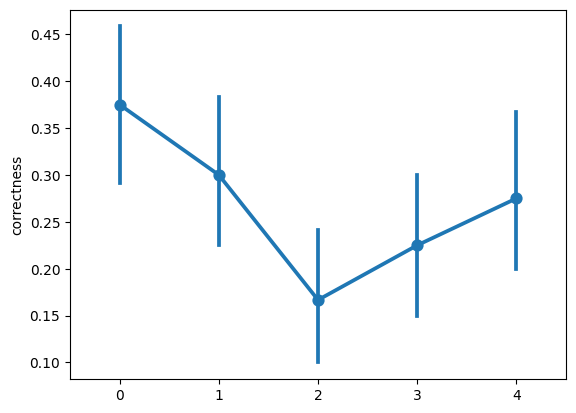

In [54]:
sns.pointplot(x = test_hitom['question_order'], y = results_hitom['correctness'])

In [63]:
results_hitom_num = main_func(llm, test_hitom_num, 5, n_repeat=3)

Processing batches: 100%|██████████| 120/120 [01:50<00:00,  1.08it/s, accuracy=0.245]

Correct: 0.245


In [55]:
results_tomi = main_func(llm, test_tomi, 5, n_repeat=3)

Processing batches: 100%|██████████| 1199/1199 [03:40<00:00,  5.43it/s, accuracy=0.42] 

Correct: 0.4199199199199199


In [61]:
results_tomi.to_csv('data/results/tomi_1.2k.csv', index=False)

In [57]:
test_tomi

Dataset({
    features: ['story', 'question', 'answer', 'question_type', 'prompt'],
    num_rows: 5994
})

<Axes: ylabel='correctness'>

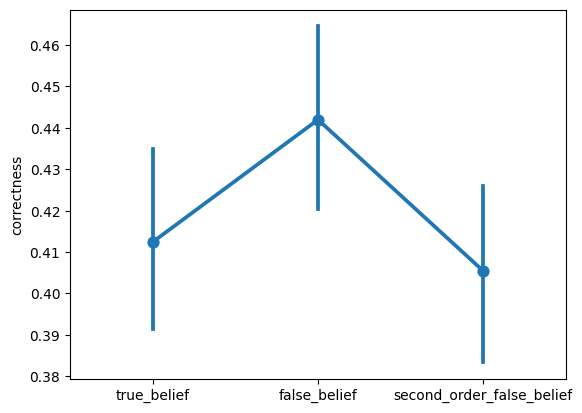

In [58]:
sns.pointplot(x = test_tomi['question_type'], y = results_tomi['correctness'])

In [64]:
results_tomi_num = main_func(llm, test_tomi_num, 5, n_repeat=3)

Processing batches: 100%|██████████| 1199/1199 [06:03<00:00,  3.30it/s, accuracy=0.492]

Correct: 0.491991991991992


In [46]:
outputs= llm.chat([test_faux['prompt'][0], test_faux['prompt'][1], test_faux['prompt'][2]], sampling_params)
print(outputs[0].outputs[0].text)
print(test_faux['answer'][0])

print(outputs[1].outputs[0].text)
print(test_faux['answer'][1])

print(outputs[2].outputs[0].text)
print(test_faux['answer'][2])

Processed prompts: 100%|██████████| 3/3 [00:00<00:00,  5.48it/s, est. speed input: 937.32 toks/s, output: 169.92 toks/s]

Yes.
Yes
<think>
Alice stated that Emma should not have said "I'm sorry about your story". This was a direct statement that contradicted Emma's intention to win the competition and was an unkind comment.
</think> 
<answer> they said they should not have said "I'm sorry about your story" </answer>
I'm sorry about your story.
<think>
The story competition was won by Alice.
</think> 
<answer> Alice </answer>
Alice


In [26]:
results_faux = main_func(llm, test_faux, 5, n_repeat=3)

Processing batches:  58%|█████▊    | 21/36 [00:05<00:03,  4.41it/s, accuracy=0.22] 

0 95 100


Processing batches: 100%|██████████| 36/36 [00:08<00:00,  4.21it/s, accuracy=0.222]

Correct: 0.2222222222222222


In [26]:
model_name = 'NS_512_ckpt773'
pd.DataFrame(results_hitom).to_csv('data/results/hitom_{}.csv'.format(model_name), index=False)
pd.DataFrame(results_tomi).to_csv('data/results/tomi_{}.csv'.format(model_name), index=False)
pd.DataFrame(results_faux).to_csv('data/results/faux_{}.csv'.format(model_name), index=False)

# 0.5B Model 
## WS 384
### HiTom
Processing batches: 100%|██████████| 120/120 [00:26<00:00,  4.51it/s, accuracy=0.25] 

Correct: 0.24957264957264957

### ToMi
Processing batches: 100%|██████████| 1199/1199 [03:20<00:00,  5.97it/s, accuracy=0.409]

Correct: 0.4088702928870293

### Faux Pas
Processing batches: 100%|██████████| 36/36 [00:05<00:00,  7.17it/s, accuracy=0.261]

Correct: 0.2608695652173913

## NS 512 773ckpt
### HiTom
Processing batches: 100%|██████████| 120/120 [00:30<00:00,  3.90it/s, accuracy=0.25] 

Correct: 0.24957264957264957

### ToMi
Processing batches: 100%|██████████| 1199/1199 [03:21<00:00,  5.94it/s, accuracy=0.391]

Correct: 0.3912605042016807

### Faux Pas
Processing batches: 100%|██████████| 36/36 [00:05<00:00,  6.23it/s, accuracy=0.247]

Correct: 0.2469879518072289